In [29]:
import pandas as pd
import numpy as np
import nltk as nltk
import xgboost as xgb

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')



from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras import regularizers
##nltk.download()
from nltk import word_tokenize
stopwords = nltk.corpus.stopwords.words('english')
import seaborn as sns
from sklearn.metrics import confusion_matrix




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
import plotly as plt
import plotly.offline as py
import plotly.graph_objs as go

In [0]:
train = pd.read_csv(r'train.csv')
test = pd.read_csv(r'test.csv')
sample = pd.read_csv(r'sample_submission.csv')

In [32]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [33]:
test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [34]:
sample.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


### Distribution samples

In [35]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
data = [go.Bar(
            x = train.author.map(z).unique(),
            y = train.author.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train.author.value_counts().values
                        ),
            text='Text entries attributed to Author'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [36]:
#Observo el top 50 de palabras sin hacer ninguna limpieza previa
all_words = train['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

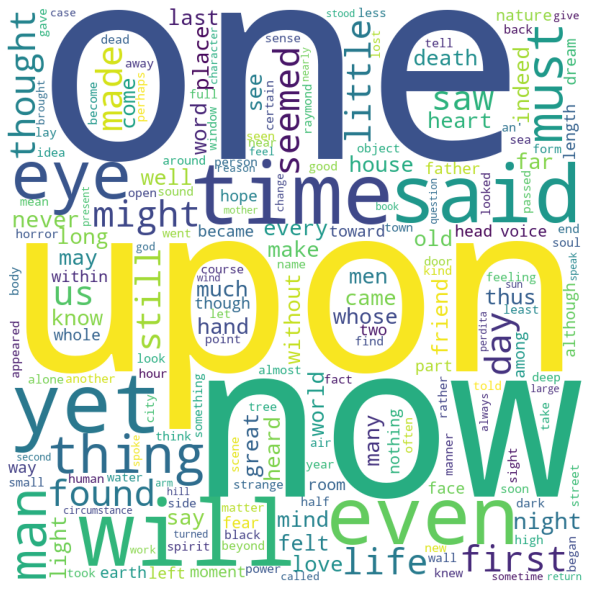

In [37]:
#genero una nube de palabras con los tres autores, sacando las stopwords
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in train.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [0]:
#eap = train[train.author=="EAP"]["text"].values
#hpl = train[train.author=="HPL"]["text"].values
#mws = train[train.author=="MWS"]["text"].values

In [0]:
#separo los textos por autor para generar nubes para cada uno de ellos
traineap= train[train.author=="EAP"]
trainhpl= train[train.author=="HPL"]
trainnws= train[train.author=="MWS"]

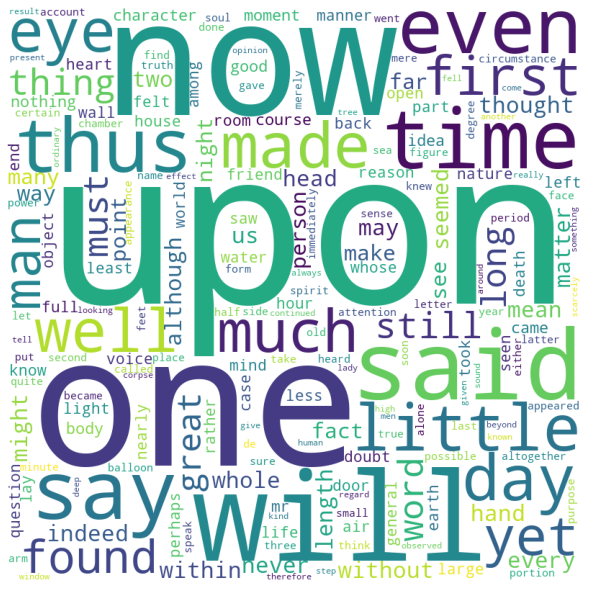

In [40]:
#nube de EAP
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in traineap.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

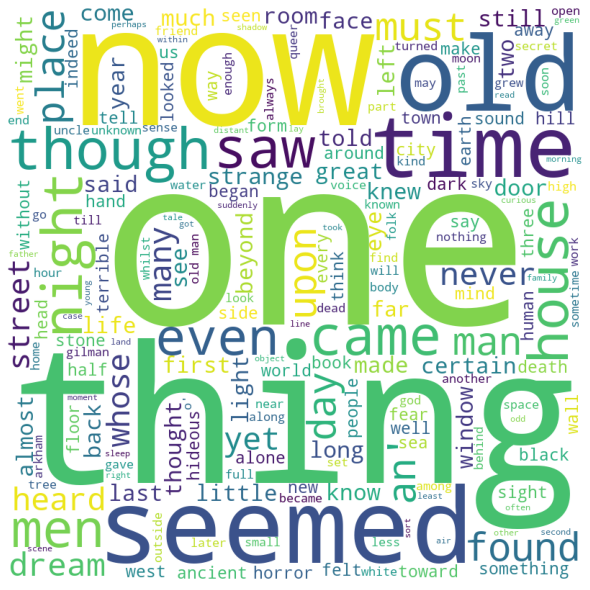

In [41]:
#nube de HPL
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in trainhpl.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

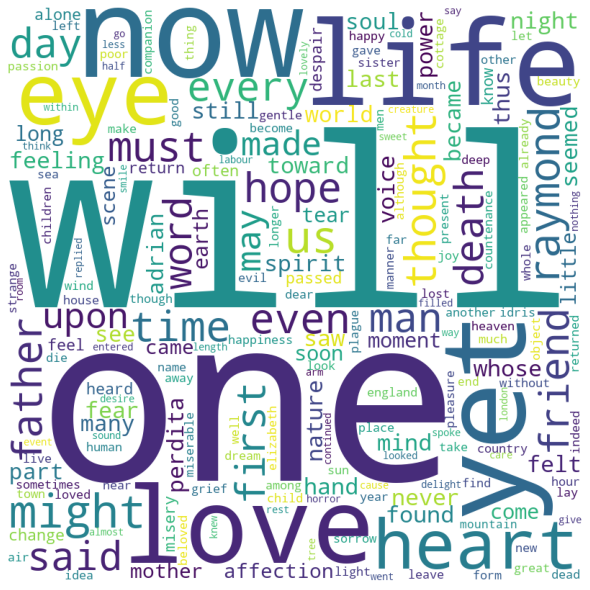

In [42]:
#nube de NWS
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in trainnws.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [0]:
## Prepare the data for modeling ###
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y =train['author'].map(author_mapping_dict)

In [0]:
#sin hacer ninguna transformción separo training y validacion
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, train_y, 
                                                  stratify=train_y, 
                                                  random_state=42, 
                                                  test_size=0.25, shuffle=True)
xtest = test.text.values

In [45]:
print (xtrain.shape)
print (xvalid.shape)
print (ytrain.shape)
print (yvalid.shape)
print (xtest.shape)

(14684,)
(4895,)
(14684,)
(4895,)
(8392,)


In [0]:
#vectorizamos haciendo el fit sobre training solamente

tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)
xtest_tfv = tfv.transform(xtest)

In [47]:
print(xtrain_tfv.shape)
print(xvalid_tfv.shape)
print(xtest_tfv.shape)

(14684, 12031)
(4895, 12031)
(8392, 12031)


In [48]:
n_words = xtrain_tfv.shape[1]
n_words

12031

In [0]:
# Nuestras etiquetas vectorizadas
y_train = np.asarray(ytrain).astype('float32')
y_valid = np.asarray(yvalid).astype('float32')

# Probamos los primeros modelos sin transformar el dataset original

In [0]:
#definimos funcion para graficar
def plot_history(name, history, legend, plot_val=True):
    fig, ax = plt.subplots(1,2,figsize=(14,6))
    fig.suptitle(name)
    
    if not isinstance(history, list):
        history = [history]
        
    for h in history:
        acc = h.history['acc']
        loss = h.history['loss']
        if plot_val:
            val_loss = h.history['val_loss']
            val_acc = h.history['val_acc']
        epochs = range(1, len(acc) + 1)

        ax[0].set_title('Loss')
        ax[0].set_xticks(ticks=epochs)
        ax[0].set_ylabel('Loss')
        
        ax[0].plot(epochs, loss)
        if plot_val:
            ax[0].plot(epochs, val_loss)
            
        ax[1].set_title('Accuracy')
        ax[1].set_xticks(ticks=list(epochs))
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuracy')
        ax[1].plot(epochs, acc)
        if plot_val:
            ax[1].plot(epochs, val_acc)
        
    ax[0].legend([l+' loss' for l in legend])
    ax[1].legend([l+' accuracy' for l in legend])

el primer modelo tiene un regularizador Ridge

In [51]:
model_L2 = Sequential(name='Modelo L2')
model_L2.add(Dense(16, activation='relu', input_shape=(n_words, ), kernel_regularizer=regularizers.l2(0.01),))
model_L2.add(Dense(16, activation='relu'))

model_L2.add(Dense(3))
model_L2.add(Activation('softmax'))
model_L2.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['acc'])
history=model_L2.fit(xtrain_tfv, y_train, batch_size=1024, epochs=20, verbose=1, validation_data=(xvalid_tfv, y_valid))

Train on 14684 samples, validate on 4895 samples
Epoch 1/20
14684/14684 [==============================] - 2s 124us/step - loss: 1.2328 - acc: 0.3993 - val_loss: 1.1108 - val_acc: 0.4035
Epoch 2/20
14684/14684 [==============================] - 2s 118us/step - loss: 1.0961 - acc: 0.4035 - val_loss: 1.0903 - val_acc: 0.4035
Epoch 3/20
14684/14684 [==============================] - 2s 118us/step - loss: 1.0868 - acc: 0.4035 - val_loss: 1.0835 - val_acc: 0.4035
Epoch 4/20
14684/14684 [==============================] - 2s 116us/step - loss: 1.0805 - acc: 0.4035 - val_loss: 1.0797 - val_acc: 0.4035
Epoch 5/20
14684/14684 [==============================] - 2s 118us/step - loss: 1.0768 - acc: 0.4035 - val_loss: 1.0762 - val_acc: 0.4035
Epoch 6/20
14684/14684 [==============================] - 2s 115us/step - loss: 1.0721 - acc: 0.4035 - val_loss: 1.0716 - val_acc: 0.4035
Epoch 7/20
14684/14684 [==============================] - 2s 114us/step - loss: 1.0661 - acc: 0.4035 - val_loss: 1.0659 - v

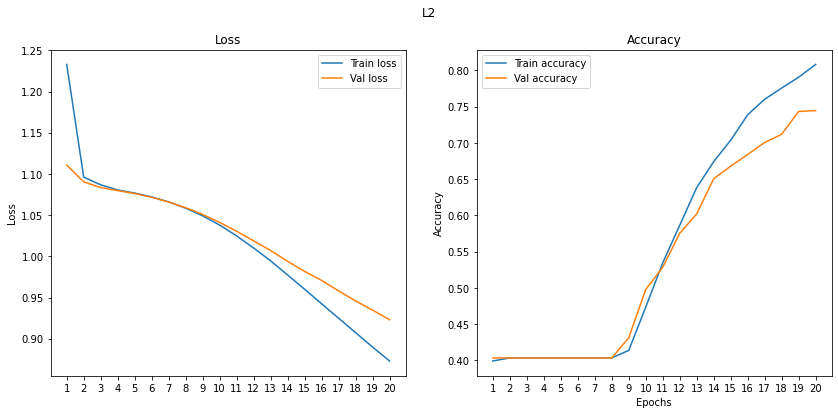

In [52]:
plot_history("L2", history, legend=['Train', 'Val'])

In [0]:
pred = model_L2.predict(xvalid_tfv)
pred_labels = pred.argmax(axis=1)

In [0]:

#plt.figure(figsize=(8,8))
#sns.heatmap(confusion_matrix(y_valid, pred_labels), fmt='g', annot=True, cmap='coolwarm', square=True,xticklabels=target_names, yticklabels=target_names_real)
#{'EAP':0, 'HPL':1, 'MWS':2}

#print(classification_report(y_valid, pred_labels, target_names=target_names))


In [56]:
model_L1 = Sequential(name='Modelo L1')
model_L1.add(Dense(16, activation='relu', input_shape=(n_words, ),
                   kernel_regularizer=regularizers.l2(0.01),))
model_L1.add(Dense(16, activation='relu'))

model_L1.add(Dense(3))
model_L1.add(Activation('softmax'))
model_L1.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['acc'])
history=model_L1.fit(xtrain_tfv, y_train, batch_size=1024, epochs=40, verbose=1, validation_data=(xvalid_tfv, y_valid))

Train on 14684 samples, validate on 4895 samples
Epoch 1/40
14684/14684 [==============================] - 2s 118us/step - loss: 1.2334 - acc: 0.3976 - val_loss: 1.1102 - val_acc: 0.4035
Epoch 2/40
14684/14684 [==============================] - 2s 112us/step - loss: 1.0934 - acc: 0.4035 - val_loss: 1.0855 - val_acc: 0.4035
Epoch 3/40
14684/14684 [==============================] - 2s 112us/step - loss: 1.0791 - acc: 0.4035 - val_loss: 1.0751 - val_acc: 0.4035
Epoch 4/40
14684/14684 [==============================] - 2s 111us/step - loss: 1.0685 - acc: 0.4036 - val_loss: 1.0672 - val_acc: 0.4045
Epoch 5/40
14684/14684 [==============================] - 2s 113us/step - loss: 1.0598 - acc: 0.4062 - val_loss: 1.0593 - val_acc: 0.4180
Epoch 6/40
14684/14684 [==============================] - 2s 113us/step - loss: 1.0479 - acc: 0.4314 - val_loss: 1.0477 - val_acc: 0.4507
Epoch 7/40
14684/14684 [==============================] - 2s 110us/step - loss: 1.0341 - acc: 0.4613 - val_loss: 1.0356 - v

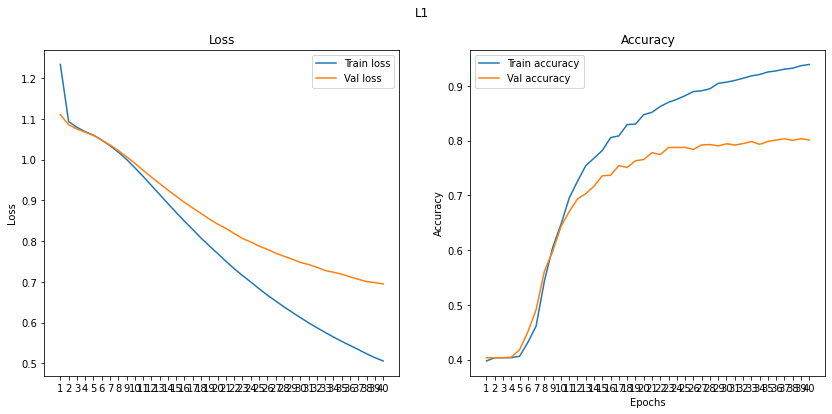

In [57]:
plot_history("L1", history, legend=['Train', 'Val'])

In [0]:
pred = model_L1.predict(xvalid_tfv)
pred_labels = pred.argmax(axis=1)

In [60]:
pred = model_L1.predict(xvalid_tfv)
pred_labels = pred.argmax(axis=1)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_valid, pred_labels), fmt='g', annot=True, cmap='coolwarm', square=True,xticklabels=target_names, yticklabels=target_names_real)
#{'EAP':0, 'HPL':1, 'MWS':2}

print(classification_report(y_valid, pred_labels, target_names=target_names))

NameError: ignored

<Figure size 576x576 with 0 Axes>

In [0]:
# Usar el método predict del modelo para obtener las probabilidades estimadas
# en x_test.
test_predictions = pd.DataFrame(model_L1.predict(xtest_tfv))
test_predictions.columns = author_mapping_dict.keys()
test_predictions['id'] = test['id']
test_predictions = test_predictions[['id','EAP','HPL','MWS']]
test_predictions.shape
test_predictions.to_csv('predictions_l1_rnn.csv', index=False)

In [0]:
model_dropout = Sequential(name="Dropout")
model_dropout.add(Dense(16, activation='relu', input_shape=(n_words, ), kernel_regularizer=regularizers.l2(0.01),))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(16, activation='relu'))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(16, activation='relu'))
model_dropout.add(Dense(3))
model_dropout.add(Activation('softmax'))
model_dropout.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['acc'])
history= model_dropout.fit(xtrain_tfv, y_train, batch_size=512, epochs=11, verbose=1, validation_data=(xvalid_tfv, y_valid))

In [0]:
plot_history("Dropout", history, legend=['Train', 'Val'])

In [0]:
mplt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_valid, pred_labels), fmt='g', annot=True, cmap='coolwarm', square=True,xticklabels=target_names, yticklabels=target_names_real)
#{'EAP':0, 'HPL':1, 'MWS':2}

print(classification_report(y_valid, pred_labels, target_names=target_names))

In [0]:
# Evaluamos la performance del modelo en el conjunto de test

results = model_dropout.evaluate(xvalid_tfv, y_valid)
results

In [0]:
# Usar el método predict del modelo para obtener las probabilidades estimadas
# en x_test.

model_dropout.predict(xvalid_tfv)

# Prediction on test data

In [0]:
test_predictions = pd.DataFrame(model_dropout.predict(xtest_tfv))
test_predictions.columns = author_mapping_dict.keys()
test_predictions['id'] = test['id']
test_predictions = test_predictions[['id','EAP','HPL','MWS']]

In [0]:
test_predictions.shape

# Exporting to Kaggle

In [0]:
test_predictions.to_csv('predictions_dropout.csv', index=False)

# classification_report

In [0]:
pred = model_dropout.predict(xvalid_tfv)
pred_labels = pred.argmax(axis=1)

In [0]:
pred.shape

In [0]:
pred_labels = pred.argmax(axis=1)

In [0]:
pred_labels.shape

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [0]:
import matplotlib.pyplot as mplt
target_names_real = ['EAP_REAL', 'HPL_REAL', 'MWS_REAL']
mplt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_valid, pred_labels), fmt='g', annot=True, cmap='coolwarm', square=True,xticklabels=target_names, yticklabels=target_names_real)
#{'EAP':0, 'HPL':1, 'MWS':2}

In [0]:
from sklearn.metrics import classification_report
target_names = ['EAP', 'HPL', 'MWS']
print(classification_report(y_valid, pred_labels, target_names=target_names))

# Probamos los mismo modelos sobre el dataset transformado (token,stopwords,stemming & lemming)

In [0]:
#usamos la libreria word_tokenize para separar no sólo las palabras sino también las puntuaciones
train["text_token"] = train["text"].str.lower().str.replace('[^a-zA-Z ]', '').apply(nltk.word_tokenize)


In [0]:
train.head()

In [0]:
#luego removemos las stopwords de nuestra lista de palabras tokenizadas
train['text_token']=train['text_token'].apply(lambda x: [item for item in x if item not in stopwords])

In [0]:
train.head()

In [0]:
#luego usamos nuevamente NLTK para hacer stemming (llevar a la raiz de la palabra)
stemmer = nltk.stem.PorterStemmer()
def stem_list(row):
    my_list = row['text_token']
    stemmed_list = [stemmer.stem(word) for word in my_list]
    return (stemmed_list)

train['text_stem'] = train.apply(stem_list, axis=1)


In [0]:
train.head()

In [0]:
#transformarmo las listas en texto nuevamente
train['text_stem']=[" ".join(text_token) for text_token in train['text_stem'].values]

In [0]:
train.head(5)

In [0]:
#now=sum(train.text.str.count("now"))
#one=sum(train.text.str.count("one"))
#print(now)
#print(one)

In [0]:
#now=sum(train.text_token.str.count("now"))
#one=sum(train.text_token.str.count("one"))
#print(now)
#print(one)

In [0]:
#now=sum(train.text_stem.str.count("now"))
#one=sum(train.text_stem.str.count("one"))
#print(now)
#print(one)

In [0]:
#ahora vuelvo a ver la distribución de palabras pero sobre los stemms
all_words = train['text_stem'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (clean & stemmed) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [0]:
#pruebo utilizar lemas en lugar de stemming
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


train['text_lemmatized'] = train.text_stem.apply(lemmatize_text)

In [0]:
train.head()

In [0]:
#transformarmo las listas en texto nuevamente
train['text_lemmatized']=[" ".join(text_lemmatized) for text_lemmatized in train['text_lemmatized'].values]

In [0]:
train.head()

In [0]:
#separo en train y validacion sobre los textos lematizados
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text_lemmatized.values, train_y, 
                                                  stratify=train_y, 
                                                  random_state=42, 
                                                  test_size=0.25, shuffle=True)
xtest = test.text.values

In [0]:
#Creamos los vectores de features utilizando solo training data y luego lo aplicamos sobre validación y test
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)
xtest_tfv = tfv.transform(xtest)

In [0]:
# Nuestras etiquetas vectorizadas
y_train = np.asarray(ytrain).astype('float32')
y_valid = np.asarray(yvalid).astype('float32')

In [0]:
#pruebo una regresion logistica
classifier = LogisticRegression(max_iter=1000)
classifier.fit(xtrain_tfv, y_train)
score_val = classifier.score(xvalid_tfv, y_valid)
score_train = classifier.score(xtrain_tfv, y_train)
print("Accuracy train:", score_train)
print("Accuracy valid:", score_val)

In [0]:
test_predictions = pd.DataFrame(classifier.predict(xtest_tfv))
test_predictions.columns = author_mapping_dict.keys()
test_predictions['id'] = test['id']
test_predictions = test_predictions[['id','EAP','HPL','MWS']]


In [0]:
test_predictions.shape

In [0]:
test_predictions.to_csv('predictions_regloglem.csv', index=False)

In [0]:
#estimo la nueva cantidad de palabras (pasamos de 12031 a 10967)
n_words = xtrain_tfv.shape[1]
n_words

In [0]:
print(xtrain_tfv.shape)
print(xvalid_tfv.shape)
print(xtest_tfv.shape)

In [0]:
model_L2 = Sequential(name='Modelo L2')
model_L2.add(Dense(16, activation='relu', input_shape=(n_words, ), kernel_regularizer=regularizers.l2(0.01),))
model_L2.add(Dense(16, activation='relu'))

model_L2.add(Dense(3))
model_L2.add(Activation('softmax'))
model_L2.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model_L2.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['acc'])

In [0]:
history=model_L2.fit(xtrain_tfv, y_train, batch_size=1024, epochs=20, verbose=1, validation_data=(xvalid_tfv, y_valid))

In [0]:
pred = model_L2.predict(xvalid_tfv)
pred_labels = pred.argmax(axis=1)

mplt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_valid, pred_labels), fmt='g', annot=True, cmap='coolwarm', square=True,xticklabels=target_names, yticklabels=target_names_real)
#{'EAP':0, 'HPL':1, 'MWS':2}

print(classification_report(y_valid, pred_labels, target_names=target_names))

In [0]:
model_L1 = Sequential(name='Modelo L1')
model_L1.add(Dense(16, activation='relu', input_shape=(n_words, ),
                   kernel_regularizer=regularizers.l2(0.01),))
model_L1.add(Dense(16, activation='relu'))

model_L1.add(Dense(3))
model_L1.add(Activation('softmax'))
model_L1.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['acc'])

In [0]:
history=model_L1.fit(xtrain_tfv, y_train, batch_size=1024, epochs=40, verbose=1, validation_data=(xvalid_tfv, y_valid))

In [0]:
plot_history("model_L1", history, legend=['Train', 'Val'])

In [0]:
pred = model_L1.predict(xvalid_tfv)
pred_labels = pred.argmax(axis=1)

mplt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_valid, pred_labels), fmt='g', annot=True, cmap='coolwarm', square=True,xticklabels=target_names, yticklabels=target_names_real)
#{'EAP':0, 'HPL':1, 'MWS':2}

print(classification_report(y_valid, pred_labels, target_names=target_names))

In [0]:
test_predictions = pd.DataFrame(model_L1.predict(xtest_tfv))
test_predictions.columns = author_mapping_dict.keys()
test_predictions['id'] = test['id']
test_predictions = test_predictions[['id','EAP','HPL','MWS']]

In [0]:
test_predictions.shape

In [0]:
test_predictions.to_csv('predictions_modeloL1lem.csv', index=False)

In [0]:
model_dropout = Sequential(name="Dropout")
model_dropout.add(Dense(16, activation='relu', input_shape=(n_words, ), kernel_regularizer=regularizers.l2(0.01),))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(16, activation='relu'))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(16, activation='relu'))
model_dropout.add(Dense(3))
model_dropout.add(Activation('softmax'))
model_dropout.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['acc'])
history3= model_dropout.fit(xtrain_tfv, y_train, batch_size=512, epochs=11, verbose=1, validation_data=(xvalid_tfv, y_valid))

In [0]:
plot_history("Dropout", history3, legend=['Train', 'Val'])

In [0]:
pred = model_dropout.predict(xvalid_tfv)
pred_labels = pred.argmax(axis=1)

mplt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_valid, pred_labels), fmt='g', annot=True, cmap='coolwarm', square=True,xticklabels=target_names, yticklabels=target_names_real)
#{'EAP':0, 'HPL':1, 'MWS':2}

print(classification_report(y_valid, pred_labels, target_names=target_names))

# Prediccion sobre test

In [0]:
test_predictions = pd.DataFrame(model_dropout.predict(xtest_tfv))
test_predictions.columns = author_mapping_dict.keys()
test_predictions['id'] = test['id']
test_predictions = test_predictions[['id','EAP','HPL','MWS']]

In [0]:
test_predictions.shape

In [0]:
test_predictions.to_csv('predictions_dropoutlem.csv', index=False)

# Using Embedding

In [0]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, train_y, 
                                                  stratify=train_y, 
                                                  random_state=42, 
                                                  test_size=0.25, shuffle=True)
xtest = test.text.values

In [0]:
#Creamos los vectores de features utilizando solo training data y luego lo aplicamos sobre validación y test
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)
xtest_tfv = tfv.transform(xtest)

In [0]:
# Nuestras etiquetas vectorizadas
y_train = np.asarray(ytrain).astype('float32')
y_valid = np.asarray(yvalid).astype('float32')

In [0]:
# usando keras tokenizamos el texto, haciendo fit solo sobre train 
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)
xtest_seq = token.texts_to_sequences(xtest)

# zero pad the sequences para que todos los vectores tengan el mismo tamaño
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index
vocab_size = len(token.word_index) + 1

In [0]:
#los indices indican cuan frecuente es la palabra, en este caso "the" es la más frecuente
print(xtrain[5])
print(xtrain_seq[5])
print(xtrain_pad[5])

In [0]:
#With the Embedding layer we have now a couple of options. One way would be to take the output of the embedding layer 
#and plug it into a Dense layer. 
#In order to do this you have to add a Flatten layer in between that prepares the sequential input for the Dense layer:  
import keras
from keras.models import Sequential
from keras import layers
embedding_dim = 300

model_3 = Sequential(name="Dropout")
model_3.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=max_len))
model_3.add(layers.Flatten())

model_3.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(Dropout(0.5))

model_3.add(Dense(16, activation='relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(16, activation='relu'))

            
model_3.add(Dense(3))
model_3.add(Activation('softmax'))

model_3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model_3.summary()

In [0]:
history = model_3.fit(xtrain_pad, y_train,
                    epochs=20,
                    verbose=1,
                    validation_data=(xvalid_pad, y_valid),
                    batch_size=512)

In [0]:
plot_history("history3", history, legend=['Train', 'Val'])

In [0]:
pred = model_3.predict(xvalid_pad)
pred_labels = pred.argmax(axis=1)

mplt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_valid, pred_labels), fmt='g', annot=True, cmap='coolwarm', square=True,xticklabels=target_names, yticklabels=target_names_real)
#{'EAP':0, 'HPL':1, 'MWS':2}

print(classification_report(y_valid, pred_labels, target_names=target_names))

In [0]:
model_3_1 = Sequential()
model_3_1.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=max_len))
model_3_1.add(SpatialDropout1D(0.5))
model_3_1.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))

model_3_1.add(Dense(16, activation='relu'))
model_3_1.add(Dropout(0.5))

model_3_1.add(Dense(16, activation='relu'))
model_3_1.add(Dropout(0.5))

model_3_1.add(Dense(3))
model_3_1.add(Activation('softmax'))
model_3_1.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['acc'])

In [0]:
history3_1=model_3_1.fit(xtrain_pad, y=y_train, batch_size=512, epochs=10, verbose=1, validation_data=(xvalid_pad, y_valid))

In [0]:
plot_history("history3_1", history3_1, legend=['Train', 'Val'])

In [0]:
pred = model_3_1.predict(xvalid_pad)
pred_labels = pred.argmax(axis=1)

mplt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_valid, pred_labels), fmt='g', annot=True, cmap='coolwarm', square=True,xticklabels=target_names, yticklabels=target_names_real)
#{'EAP':0, 'HPL':1, 'MWS':2}

print(classification_report(y_valid, pred_labels, target_names=target_names))

In [0]:
test_predictions = pd.DataFrame(model_3_1.predict(xtest_pad))
test_predictions.columns = author_mapping_dict.keys()
test_predictions['id'] = test['id']
test_predictions = test_predictions[['id','EAP','HPL','MWS']]





In [0]:
test_predictions.shape

In [0]:
test_predictions.to_csv('predictionsmodel_3_1.csv', index=False)

In [0]:
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(y_train)
yvalid_enc = np_utils.to_categorical(y_valid)

# Using trained embedding

In [0]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [0]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix(r'.txt',token.word_index, embedding_dim)

In [0]:
#79.8% del vocabulario es cubierto por el modelo pre entrenado
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

In [0]:
model_4 = Sequential()
model_4.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model_4.add(SpatialDropout1D(0.3))
model_4.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model_4.add(Dense(16, activation='relu'))
model_4.add(Dropout(0.5))

model_4.add(Dense(16, activation='relu'))
model_4.add(Dropout(0.5))

model_4.add(Dense(3))
model_4.add(Activation('softmax'))
model_4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
history4=model_4.fit(xtrain_pad, y=y_train, batch_size=512, epochs=70, verbose=1, validation_data=(xvalid_pad, y_valid))

In [0]:
plot_history("model_4", history4, legend=['Train', 'Val'])

In [0]:
pred = model_4.predict(xvalid_pad)
pred_labels = pred.argmax(axis=1)

mplt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_valid, pred_labels), fmt='g', annot=True, cmap='coolwarm', square=True,xticklabels=target_names, yticklabels=target_names_real)
#{'EAP':0, 'HPL':1, 'MWS':2}

print(classification_report(y_valid, pred_labels, target_names=target_names))

embedding glove+ lstm

In [0]:
model_5 = Sequential()
model_5.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model_5.add(SpatialDropout1D(0.3))
model_5.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model_5.add(Dense(16, activation='relu'))

model_5.add(Dense(16, activation='relu'))

model_5.add(Dense(3))
model_5.add(Activation('softmax'))
model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
history5=model_5.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=50, verbose=1, validation_data=(xvalid_pad, yvalid_enc))

In [0]:
plot_history("model_5", history5, legend=['Train', 'Val'])

In [0]:
pred = model_5.predict(xvalid_pad)
pred_labels = pred.argmax(axis=1)

mplt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_valid, pred_labels), fmt='g', annot=True, cmap='coolwarm', square=True,xticklabels=target_names, yticklabels=target_names_real)
#{'EAP':0, 'HPL':1, 'MWS':2}

print(classification_report(y_valid, pred_labels, target_names=target_names))

In [0]:
print(classification_report(y_valid, pred_labels, target_names=target_names))

In [0]:
test_predictions = pd.DataFrame(model_5.predict(xtest_pad))
test_predictions.columns = author_mapping_dict.keys()
test_predictions['id'] = test['id']
test_predictions = test_predictions[['id','EAP','HPL','MWS']]

In [0]:
test_predictions.shape

In [0]:
test_predictions.to_csv('predictionsmodel_5.csv', index=False)

In [0]:
model_6 = Sequential()
model_6.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

model_6.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model_6.add(Dense(16, activation='relu'))
model_6.add(Dropout(0.5))

model_6.add(Dense(16, activation='relu'))
model_6.add(Dropout(0.5))

model_6.add(Dense(3))
model_6.add(Activation('softmax'))
model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
history6=model_6.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=70, verbose=1, validation_data=(xvalid_pad, yvalid_enc))

In [0]:
pred = model_6.predict(xvalid_pad)
pred_labels = pred.argmax(axis=1)

mplt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_valid, pred_labels), fmt='g', annot=True, cmap='coolwarm', square=True,xticklabels=target_names, yticklabels=target_names_real)
#{'EAP':0, 'HPL':1, 'MWS':2}

print(classification_report(y_valid, pred_labels, target_names=target_names))

In [0]:
model_7 = Sequential()
model_7.add(Embedding(len(word_index) + 1, 300, input_length = max_len))
model_7.add(GRU(300, dropout = 0.2, recurrent_dropout = 0.2))
model_7.add(Dense(3, activation = 'softmax'))
model_7.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
model_7.summary()

In [0]:
history7=model_7.fit(xtrain_pad, y=y_train, batch_size=512, epochs=70, verbose=1, validation_data=(xvalid_pad, y_valid))

In [0]:
#prediccion sobre test
#model.predict(x=xtest_pad)